<a href="https://colab.research.google.com/github/journalWheat/CSI4106-Project1/blob/main/CSI4106_Project1_JaredWagner_GeneralForm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Predicting wine quality with naive bayes, logistic regression, and multi-layer perceptron**

# GROUP 97
Intellectual property of JARED WAGNER (Student #300010832), Fall 2022.

Submitted for CSI4106, Introduction to Artificial Intelligence. 

Student #300010832

# Introduction and goals
The goal is to....

Because... this has applications in ...

examples...

In [105]:
# setup for the project
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#data source: https://www.kaggle.com/datasets/rajyellow46/wine-quality
df_location = 'https://raw.githubusercontent.com/journalWheat/CSI4106-Project1/main/winequalityN.csv' 
sample_location = 'https://raw.githubusercontent.com/journalWheat/CSI4106-Project1/main/sample.csv'
target = 'type'

raw_df = pd.read_csv(df_location).dropna().sample(n=len(pd.read_csv(df_location).dropna()),random_state=1)
med_sample_df = raw_df[100:601].copy() # sample of 500
small_sample_df = raw_df[:100].copy() # sample of 100

# Analyzing the data

The dataset used for this report was provided through Kaggle: https://www.kaggle.com/datasets/yasserh/wine-quality-dataset

This dataset has 6463 samples and 12 features. This is a binary classification task, because I will use this data to classify wines as 'red' or 'white.'

From the statistics below, there are no rows with missing values in this data set (since the count for each feature is equal to the count of the target).

In [106]:
# get some statistics
print(raw_df.isnull().sum())
print(raw_df.describe())

type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    6463.000000       6463.000000  6463.000000     6463.000000   
mean        7.217755          0.339589     0.318758        5.443958   
std         1.297913          0.164639     0.145252        4.756852   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        3.000000   
75%         7.700000          0.400000     0.390000        8.100000   
max        15.900000          1.580000     1.660000       65.800000   

         

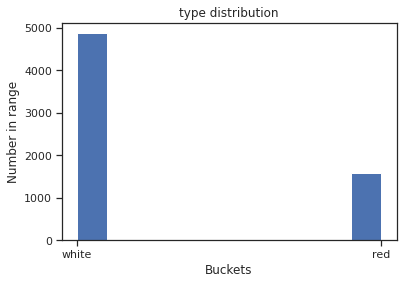

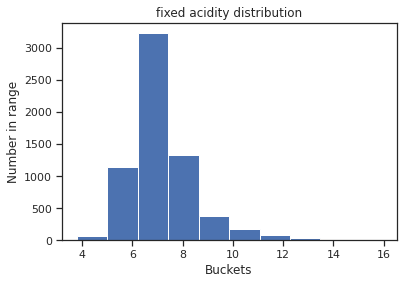

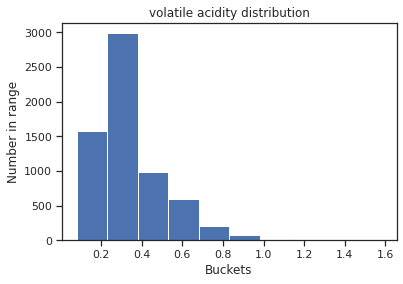

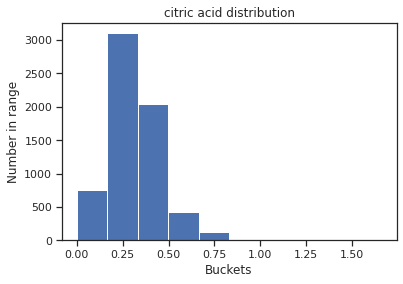

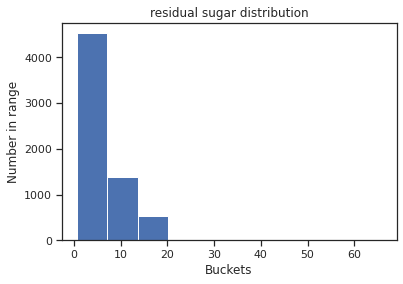

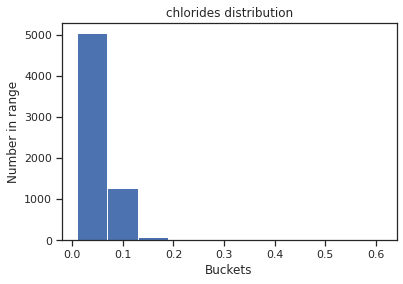

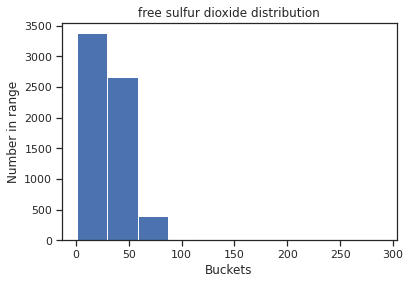

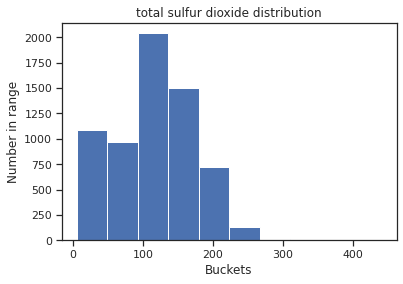

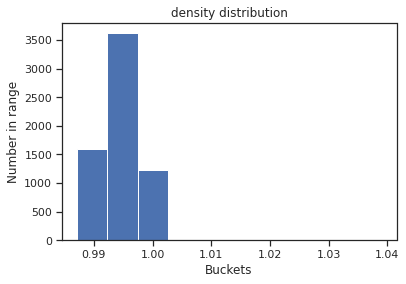

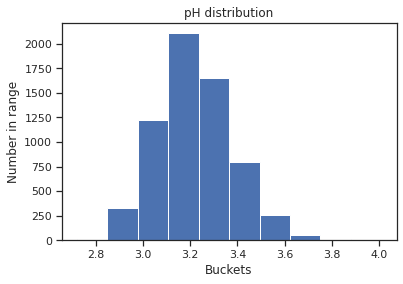

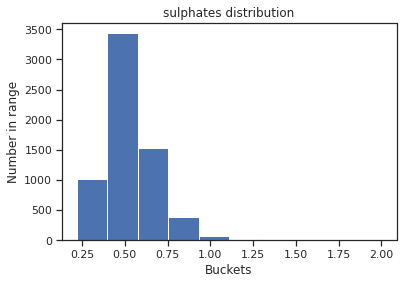

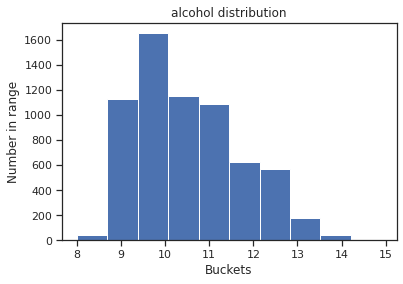

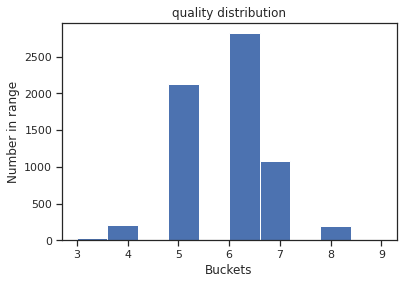

In [107]:
# plot histograms to see distributions of data
for column in raw_df:
  plt.hist(raw_df[column])
  plt.xlabel('Buckets')
  plt.ylabel('Number in range')
  plt.title(column + ' distribution')
  plt.show()

At a glance, these plots look good. There is a mix of features with relatively normal and non-normal distribution, which may help classify samples from the dataset.

This seems like a more reasonable classification system for the wines, given the limited number of samples available.

# Feature engineering
## Strategizing feature selection

The features provided in the dataset look promising, but to get an idea of whether they are actually usable I construct a scatterplot matrix.

In [ ]:
# This code simply prints a scatterplot matrix for the features in a small sample of the data

#sns.set_theme(style='ticks')
#sns.pairplot(small_sample_df,hue=target)

From the scatterplot matrix, my first observation is that the data *is* separable using the class 'type.' There exist multiple plots where the two classes of wine seem to be separable by a line. This is important, because it means that the classes are probably learnable by an algorithm. However, simply selecting features from these scatterplots would be a naive approach because:
1. I can't tell which features are most important from the plots.
2. Feature selection should normally be catered to the models under consideration, and the models I will be building have unique strengths and weaknesses.
3. Some feature graphs are difficult to interpret, such as any of the plots with 'quality' as a metric.

Therefore, instead of relying on graph interpretation I choose three different analytical approaches for each training run:

- **First run:** feature selection using relative mutual information scores assigned to each feature using scikit-learn.feature_selection.mutual_info_classif(). This is a "naive approach," in the sense that the *number* of features I use will be arbitrary.
- **Second run:** recursive feature elimination, where features with the weakest predictive power are sequentially removed from a model.
- **Third run:** sequential forwards feature selection, where features with the strogest predictive power are sequentially added to a model.

These strategies were chosen by consulting the Kaggle Education module on feature engineering, as well as an article provided by Scikit-learn on feature selection. These are included under 'References' at the bottom of the page.

There are two main reasons why I selected these strategies. First, all three strategies provide an analytical framework to select features according to their predictive power. Second, they are all "different" enough (i.e. they use different underlying fitting models) that they will likely choose different features.

For each of these runs, I use a sample dataset of 600 samples which I took when I loaded the raw data. Admittedly: the size of the sample dataset is somewhat arbitrary since I did not check how many samples I would need for statistical significance.

##**First run** feature selection using mutual information scores

To start with, I will use a feature utility metric to measure how strongly associated each feature is with the target variable.

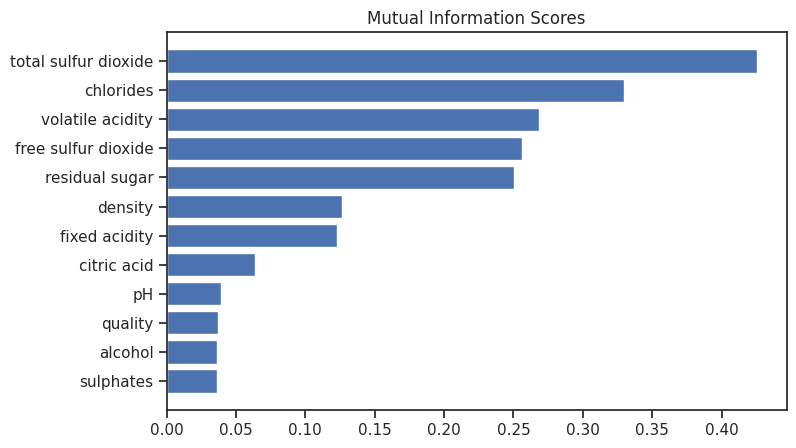

In [109]:
# NOTICE: this code is modified from: https://www.kaggle.com/code/ryanholbrook/mutual-information
X = small_sample_df.copy()
y = X.pop(target)

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

####################

from sklearn.feature_selection import mutual_info_classif

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  # show a few features with their MI scores

####Display
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

###Interpretation
From the bar graph, the top 4 ranked features are:
- total sulfur dioxide
- chlorides
- volatile acidity
- residual sugar

In [110]:
first_run_features = {'total sulfur dioxide','chlorides','volatile acidity','residual sugar'}

##**Second run** feature selection using recursive feature elimination

Recursive Feature Elimination works by fitting a model using all features, removing the least useful feature, and then repeating the process until a desired number of features are left. Since four features were selected in the previous section, I will also select four using this technique.

One drawback to this method for my application (fitting three different models) is that RFE optimizes feature selection to the underlying model. Since I will be using a Decision Tree Classifier as the underlying model, that means the features I select will not necessarily be the optimal features for the models I will train later.

In [111]:
# NOTICE: first, I had tried to use this code: https://www.kaggle.com/code/carlmcbrideellis/recursive-feature-elimination-rfe-example/notebook
# NOTICE: this source was also consulted on RFE: https://machinelearningmastery.com/rfe-feature-selection-in-python/
# NOTICE: last, I took some code from https://www.youtube.com/watch?v=vxdVKbAv6as
import sklearn
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
df = small_sample_df.copy()

# inputs
X = df.drop(columns=[target], axis=1)
y = df[target]
# outputs

# define RFE
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=4)

#fit the model
rfe.fit(X, y)

for i, col in zip(range(X.shape[1]), X.columns):
  print(f"{col} selected={rfe.support_[i]} rank={rfe.ranking_[i]}")

fixed acidity selected=False rank=7
volatile acidity selected=False rank=9
citric acid selected=False rank=8
residual sugar selected=False rank=6
chlorides selected=True rank=1
free sulfur dioxide selected=False rank=5
total sulfur dioxide selected=True rank=1
density selected=False rank=4
pH selected=False rank=3
sulphates selected=False rank=2
alcohol selected=True rank=1
quality selected=True rank=1


From RFE, the chosen features are:
- chlorides
- total sulfur dioxide
- pH
- alcohol

In [112]:
second_run_features = {'chlorides','total sulfur dioxide','pH','alcohol'}

##**Third Run** feature selection using sequential forward feature selection

Sequential forward feature selection is like the opposite of recursive feature elimination. Instead of building a model with all features and then removing less important features, this technique starts with the "best" feature and builds the model from there.

One main difference between this implementation of FFS vs. the implementation of RSE above is also the underlying method. For FFS, I use a Random Forest Classifier to build the model for feature selection.

In [114]:
# code was used from: https://www.youtube.com/watch?v=POCvLGRLDzM
# also consulted the documentation for SequentialFeatureSelector: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html#sklearn.feature_selection.SequentialFeatureSelector
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SequentialFeatureSelector

df = small_sample_df.copy()

# inputs
X = df.drop(columns=[target], axis=1)
y = df[target]

# train, test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3)
X_train.shape

# FFS w/ Random Forest
sfs = SequentialFeatureSelector(RandomForestClassifier(n_jobs=-1), n_features_to_select=4, direction='forward', cv=5).fit(X_train, y_train)


KeyboardInterrupt: ignored

In [ ]:
print(sfs.get_feature_names_out())

###Interpretation
Using sequential forward feature selection with a decision tree as the underlying model, the features selected are:
- fixed acidity
- residual sugar
- total sulfur dioxide
- density

In [115]:
third_run_features = {'fixed acidity', 'residual sugar', 'total sulfur dioxide', 'density'}

##Summary and reflection
In the previous sections, I chose the following features for each training run.

- **First run:** total sulfur dioxide, chlorides, volatile acidity, residual sugar
- **Second run:** chlorides, total sulfur dioxide, pH, alcohol
- **Third run:** fixed acidity, residual sugar, total sulfur dioxide, density

Of these features, some appeared multiple times between selection methods. In order of incidence:
- **Appeared across all selections:** total sulfur dioxide
- **Appeared across two selections:** chlorides, residual sugar
- **Appeared in only one selection:** volatile acidity, pH, alcohol, fixed acidity, density

This suggests that 'total sulfur dioxide,' 'chlorides', and 'residual sugar,' have a strong predictive value for the target variable, but that the other variables are sensitive to the underlying model. Remember that for each feature selection run, three different underlying models were used to score the predicive value of a feature. In order, these were: k-nearest neighbors, decision tree, and random forest algorithms.

The implication of this seems to be that all sets contain at least one strong predictor (total sulfur dioxide), but that the other variables will be more-or-less useful depending on the underlying model used. For example,

In [116]:
print(first_run_features)
print(second_run_features)
print(third_run_features)

{'total sulfur dioxide', 'volatile acidity', 'chlorides', 'residual sugar'}
{'pH', 'total sulfur dioxide', 'chlorides', 'alcohol'}
{'fixed acidity', 'total sulfur dioxide', 'density', 'residual sugar'}


#Encoding
Each algorithm I am implementing needs to take different data. I have split this section into three subsections, each corresponding to how I am encoding the data for each algorithm. 

In each section, I also go to the liberty of encoding the data for each run. What that means is that when I finish encoding, I will end up with nine datasets total:
- run_one_bayes_df, run_two_bayes_df, run_three_bayes_df
- run_one_logistic_df, run_two_logistic_df, run_three_bayes_df
- run_one_MLP_df, run_two_MLP_df, run_three_MLP_df

Each of these datasets actually contain a subset of the data in raw_df, where:
1. I only keep the features I need for each run.
2. The data is encoded according to the rules I lay out in this section, which are designed for the specific algorithm I am training.

###Encoding for Naive Bayes
There's a big, big problem with my features: they are all continous! To tackle that problem, I'll:
1. Put the data into n equally distributed buckets corresponding to the % of samples in that range. For example, for n=3, values in the first 33% of samples are placed in bucket 1, the next 33% are placed in bucket 2, and the remaining samples are placed in bucket 3.
2. Using one-hot-encoding, transform the row into n mutually-exclusive rows with values of either 1 or 0.

I should note that point #1 has some hidden assumptions with potential consequences. By splitting the data evenly into n buckets, I am assuming that the target classes are distributed differently enough across those buckets for the condional probabilities to differentiate which target class is most likely within that range.

This is a bold assumption. What if, by chance, the data is distributed such that the most dominant target value (red) is most likely across all of the buckets for every feature? Then, the algorithm will be useless because it will always guess that the wine is red.

On the other hand: using too many buckets for the data is also a problem. Consider that keeping the data continuous is like having an infinite number of buckets, in which case the conditional probability of any particular point is equal.

In [117]:
 # qcut: https://stackoverflow.com/questions/53963183/how-to-use-kbinsdiscretizer-to-make-continuous-data-into-bins-in-sklearn
 # get_dummies: https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python

def encodeForBayes (raw, target, features, n_buckets):
  # get a dataframe with the features we care about
  df = raw[features].copy()

  # use Pandas to replace the values in each dataframe with the quantile they belong to
  for column in df:
    df[column] = pd.qcut(df[column], q=(n_buckets+1), labels=False)

  # expand each column out into mutually exclusive columns
  for column in df:
    onehot_columns = pd.get_dummies(df[column], prefix=column+' ',prefix_sep='', drop_first=True)
    df = pd.concat([df, onehot_columns],axis=1)
    df = df.drop(column, axis=1)

  # add the target back at the end of the dataframe ... everything have been done inplace, so this is okay
  df = pd.concat([raw_df[target],df],axis=1)
  #df[target] = raw[target].copy()

  return df

n=4
run_one_bayes_df = encodeForBayes(raw_df, target, first_run_features, n)
run_two_bayes_df = encodeForBayes(raw_df, target, second_run_features, n)
run_three_bayes_df = encodeForBayes(raw_df, target, third_run_features, n)

# Making cuts for k-fold cross validation
###Theory
K-fold cross validation is a method used to prevent overfitting. Overfitting occurs when a model performs well on training data, but fails to perform on real data. Through this process, data is split into k groups. Then, the model is trained k times (using a different data fold k for testing). By evaluating the performance of the model on all k runs, one obtains a better understanding on the general health of the model compared to if the model had been trained and tested only once.

###Applying k-fold cross validation to the wine dataset

"Randomness" is a subject worth exploring before I split the data using k-fold cross validation. For some datasets where samples are dependent, randomizing the data would be innapopriate (for example, some data sets where samples are dependent on time). However, the samples in my data are independent, so I want to reflect that in each of the folds I take.

This observation might initially seem to contradict my code below, where I do not shuffle the data. This is because when the data was initially read from CSV, it was shuffled using a pseudorandom seed. This approach was chosen so that the work in this notebook would be reproducible. Because the data was shuffled from a seed, that means anybody can shuffle the CSV the same way as was done in this report.

For this report, 10-fold cross validation will be employed since this is a common choice in data science literature. Examining the impact of taking different folds could be an interesting follow-up analysis, but is outside of the scope of this report.

Theory taken from:
https://machinelearningmastery.com/k-fold-cross-validation/#:~:text=Cross%2Dvalidation%20is%20a%20resampling,is%20to%20be%20split%20into.

https://scikit-learn.org/stable/modules/cross_validation.html

In [138]:
# Guide on KFold: https://www.section.io/engineering-education/how-to-implement-k-fold-cross-validation/
# NOTE THAT: I use some code from https://www.youtube.com/watch?v=gJo0uNL-5Qw for all of the KFold sections of this report
from sklearn.model_selection import KFold

# prepare 10 splits
kf = KFold(n_splits=10, random_state=None, shuffle=False)

# show what this looks like with a small subset of the data
for train_index, test_index in kf.split(df):
  print(train_index, test_index)

#after I complete the next section with Naive Bayes, I'll use these folds to test the model

[10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57
 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81
 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99] [0 1 2 3 4 5 6 7 8 9]
[ 0  1  2  3  4  5  6  7  8  9 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57
 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81
 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99] [10 11 12 13 14 15 16 17 18 19]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 30 31 32 33
 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57
 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81
 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99] [20 21 22 23 24 25 26 27 28 29]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 

#The models
The algorithms I use to train the models for each run are placed in this section.
###Naive Bayes
Main ideas:
- Use Bayes Theorem
  - To compare the probability of different classes, we just need to look at P(Y|X) = P(X|Y)P(Y) (since the denominator of Bayes is the same for all values)

In [ ]:
# TEMINOLOGY
# X_train -> a training dataset with features and target variable
# X_test -> a testing dataset with features and target variable
# Y -> the name of the target variable; could also be considered a set of possible classes
# X -> a set of features
# x -> a particular feature
# y -> a particular class of the target variable

In [186]:
# implementation using sklearn.naive_bayes.CategoricalNB
# documentation: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
from sklearn.naive_bayes import MultinomialNB

def naive_bayes(df):
  # prepare the data. GaussianNB takes a list of features, and Y takes a list of the corresponding target values
  X_train = df.drop(columns=target, axis=1).values.tolist()
  Y_train = df[target].values.tolist()

  test_df = run_one_bayes_df[3000:6000]
  X_test = test_df.drop(columns=target, axis=1).values.tolist()
  Y_test = test_df[target].values.tolist()
  # fit the model
  clf = MultinomialNB(fit_prior=True)
  clf.fit(X_train, Y_train)
  i=0
  correct = 0
  for test in clf.predict(X_test):
    if (test==Y_test[i]):
      correct += 1
    i += 1
  print(correct/i)


naive_bayes(run_one_bayes_df[0:2000])

0.9593333333333334


In [ ]:
# code modified from: https://github.com/Suji04/ML_from_Scratch/blob/master/naive%20bayes.ipynb



# Returns list of probabilities for a sorted list of labels
def calc_prior(X_train, Y, labels):
  priors = []
  total = len(X_train[Y])
  for label in labels:
    priors.append(len(X_train[X_train[Y] == label])/total)

# Returns P(feature|label)
def calc_feature_given_label(features, label):
  pass

# Returns a list of predictions for X_test
def naive_bayes_classifier(X_train, X_test, Y):
  # get feature names
  features = list(df.drop(columns=Y, axis=1))
  # get labels/classes of Y
  labels = sorted(list(df[Y].unique()))
  # calculate priors
  prior = calc_prior(X_train, Y, labels)

  # transpose data so we can iterate over samples
  X_train = X_train.transpose()
  # iterate over samples
  for x in X_train:
    # keep track of probability for each class. Index in likelihood corresponds to the label I stored above.
    likelihood=[1]*len(labels)
    for j in range(len(labels)): # iterate over labels
      for i in range(len(features)):
        print(x,j,i)


  #####################TESTING
  print(features)
  print(labels)
  print(prior)
  ############################

naive_bayes_classifier(run_one_bayes_df[0:100],run_one_bayes_df[100:200],target)

In [ ]:
# TEMINOLOGY
# X_train -> a training dataset with features and target variable
# X_test -> a testing dataset with features and target variable
# Y -> the name of the target variable; could also be considered a set of possible classes
# X -> a set of features
# x -> a particular feature
# y -> a particular class of the target variable

# returns a list with the prior probability of each class
def calculate_prior(X_train, Y):
  X_train = X_train.copy() # to ensure the original is unaltered
  labels = sorted(list(X_train[Y].unique())) # list of classes in Y
  Y_count = len(X_train[Y])
  prior = [] # empty list of prior probabilities

  for each_class in labels:
    class_count = X_train[Y].value_counts()[each_class]
    prior.append(class_count / Y_count)

  return prior

# returns the probability of feature given Y=y
def calculate_feature_probability(X, feature, Y, label):
  count_label = X[Y].value_counts()[label]
  label_df = X[X[Y] == label]
  count_feature = len(label_df[label_df[feature] == 1])
  prob_feat_given_label = count_feature/count_label
  return prob_feat_given_label


# from: https://github.com/Suji04/ML_from_Scratch/blob/master/naive%20bayes.ipynb
# returns a dataframe with conditional probabilities P(x|y)
def naive_bayes_classifier(df, X, Y):
    # get feature names
    features = list(df.drop(Y, axis=1).columns)

    # calculate prior
    prior = calculate_prior(df, Y)

    Y_pred = []
    # loop over every data sample
    for x in X:
        # calculate likelihood
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_feature_probability(df, features[i], Y, labels[j])

        # calculate posterior probability (numerator only)
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        Y_pred.append(np.argmax(post_prob))

    return np.array(Y_pred) 
  
naive_bayes_classifier(run_one_bayes_df[0:100],run_one_bayes_df[101:2000],target)


#Run 1: training the models
**Features used:**


###Naive Bayes

In [ ]:
priorRed = calculatePrior(run_one_bayes_df, target, 'red')
priorWhite = calculatePrior(run_one_bayes_df, target, 'white')

###Logistic regression

###Multilayer Preceptron

#Run 2: training the models

#Run 3: training the models

# References

Data source: https://www.kaggle.com/datasets/rajyellow46/wine-quality

Feature utility metric reference: https://www.kaggle.com/code/ryanholbrook/mutual-information

Categorical variables: https://www.kaggle.com/code/alexisbcook/categorical-variables/tutorial

https://www.kaggle.com/code/ryanholbrook/mutual-information

(Reference on feature selection: https://scikit-learn.org/stable/modules/feature_selection.html)

https://guhanesvar.medium.com/feature-selection-based-on-mutual-information-gain-for-classification-and-regression-d0f86ea5262a

Kaggle feature engineering tutorials: https://www.kaggle.com/learn/feature-engineering

# DISCLOSURE

This is the third dataset I selected for this project. Since there may have been influence on this iteration by the work I did on my last two datasets, I have included references to the resources I used in the first iteration of this project under "Works Cited."

Iteration 1 is also available on Github: https://github.com/journalWheat/CSI4106Project1-JaredWagner

As well as iteration 2: 
https://github.com/journalWheat/CSI4106-Project1-JaredWagner-WaterPotability